In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import numpy as np
import pandas as pd
import os
import sys
import json
import pickle
sns.reset_orig()
sns.set_palette('crest')
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from models import get_models
from catalogue import collect_catalogue_from_ATNF

# Set the output directories here
outdir_10 = 'outdir_10_percent_threshold'
outdir_20 = 'outdir_20_percent_threshold'

In [2]:
with open(f'../catalogue/catalogue.pkl', 'rb') as f:
    catalogue = pickle.load(f)
def load_results(outdir: str, var: str):
    with open(f'../output/results_{var}_from_{outdir}.json', 'r', encoding='utf-8-sig') as f:
        results = pd.DataFrame(json.load(f)).T
        results['best_fitting'] = results.iloc[:, :].idxmax(axis=1) if var == 'log_evidence' else results.iloc[:, :].idxmin(axis=1)
    return results
results_10 = load_results(outdir_10, 'log_evidence')
results_20 = load_results(outdir_20, 'log_evidence')
results_10_bf = results_10.drop(columns='best_fitting').sub(results_10['simple_power_law'], axis=0).drop(columns='simple_power_law')
results_20_bf = results_20.drop(columns='best_fitting').sub(results_20['simple_power_law'], axis=0).drop(columns='simple_power_law')
with open(f'../output/results_param_estimates_from_{outdir_10}.json', 'r', encoding='utf-8-sig') as f:
    param_est_10 = json.load(f)
with open(f'../output/results_param_estimates_from_{outdir_20}.json', 'r', encoding='utf-8-sig') as f:
    param_est_20 = json.load(f)

Systematic error distribution:


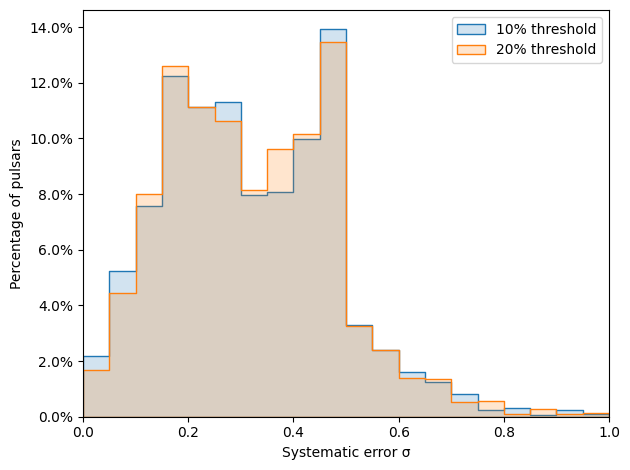

Systematic errors > 0.5 (10% threshold): 458 / 4380
Systematic errors > 0.5 (20% threshold): 447 / 4380


In [3]:
print('Systematic error distribution:')
    
model_dict = get_models('simple_power_law;broken_power_law;log_parabolic_spectrum;high_frequency_cut_off_power_law;low_frequency_turn_over_power_law')

sigma_10, sigma_20 = {}, {}
for model in model_dict:
    sigma_10[model], sigma_20[model] = [], []
    for jname in results_10.index:
        if jname not in catalogue.cat_dict or model not in param_est_10[jname]:
            continue
        sigma_10[model].append(param_est_10[jname][model]['median'][-1])
    for jname in results_20.index:
        if jname not in catalogue.cat_dict or model not in param_est_20[jname]:
            continue
        sigma_20[model].append(param_est_20[jname][model]['median'][-1])  # the last parameter is the error
        
sigma_all_10 = np.concatenate([sigma_10[model] for model in model_dict])
sigma_all_20 = np.concatenate([sigma_20[model] for model in model_dict])

fig, ax = plt.subplots()
sns.histplot(sigma_all_10, binwidth=0.05, binrange=(0, 1), kde=False, label='10% threshold', stat='probability', element='step', color='tab:blue', alpha=0.2, ax=ax)
sns.histplot(sigma_all_20, binwidth=0.05, binrange=(0, 1), kde=False, label='20% threshold', stat='probability', element='step', color='tab:orange', alpha=0.2, ax=ax)
ax.set_xlim(0, 1)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.set_xlabel('Systematic error σ')
ax.set_ylabel('Percentage of pulsars')
ax.legend()
plt.tight_layout()
plt.savefig('Systematic error distribution.pdf', bbox_inches='tight')
plt.show()

print(f'Systematic errors > 0.5 (10% threshold): {np.sum(sigma_all_10 > 0.5)} / {len(sigma_all_10)}')
print(f'Systematic errors > 0.5 (20% threshold): {np.sum(sigma_all_20 > 0.5)} / {len(sigma_all_20)}')

In [4]:
print('Broken power law: how many of them are having only one point before or after ν_b?', end=' ')

cnt_bpl, cnt_bpl_filtered = 0, 0
for jname in results_10.index:
    if results_10.loc[jname, 'best_fitting'] == 'broken_power_law':
        cnt_bpl += 1
        ν_b = param_est_10[jname]['broken_power_law']['median'][0]
        X_sorted = np.sort(catalogue.cat_dict[jname]['X'])
        if np.sum(X_sorted < ν_b) <= 1 or np.sum(X_sorted > ν_b) <= 1:
            cnt_bpl_filtered += 1
print(f'{cnt_bpl_filtered} / {cnt_bpl}.')

print('Low-frequency turn-over power law: how many of them are having only one point before or after ν_c?', end=' ')

cnt_lfto, cnt_lfto_filtered = 0, 0
for jname in results_10.index:
    if results_10.loc[jname, 'best_fitting'] == 'low_frequency_turn_over_power_law':
        cnt_lfto += 1
        ν_c = param_est_10[jname]['low_frequency_turn_over_power_law']['median'][0]
        X_sorted = np.sort(catalogue.cat_dict[jname]['X'])
        if np.sum(X_sorted < ν_c) <= 1 or np.sum(X_sorted > ν_c) <= 1:
            cnt_lfto_filtered += 1
print(f'{cnt_lfto_filtered} / {cnt_lfto}.')

Broken power law: how many of them are having only one point before or after ν_b? 99 / 287.
Low-frequency turn-over power law: how many of them are having only one point before or after ν_c? 39 / 104.


Flux density comparison with the latest ATNF Pulsar Catalogue and our dataset:
Without systematic error:
Number of points: 716
Number of outliers: 48
Outliers by model:
- simple_power_law: 4
- broken_power_law: 17
- log_parabolic_spectrum: 16
- high_frequency_cut_off_power_law: 5
- low_frequency_turn_over_power_law: 6


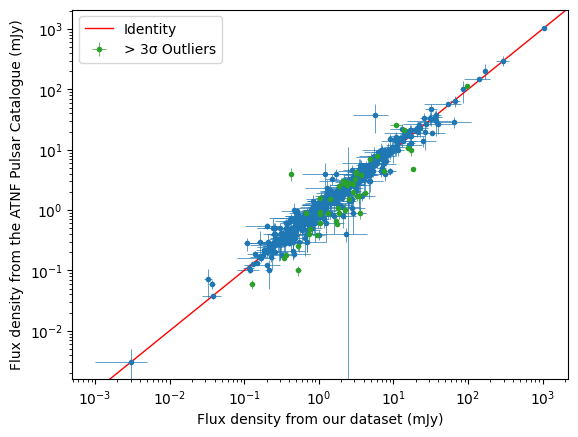

With systematic error:
Number of points: 716
Number of outliers: 9
Outliers by model:
- simple_power_law: 1
- broken_power_law: 2
- log_parabolic_spectrum: 3
- high_frequency_cut_off_power_law: 1
- low_frequency_turn_over_power_law: 2


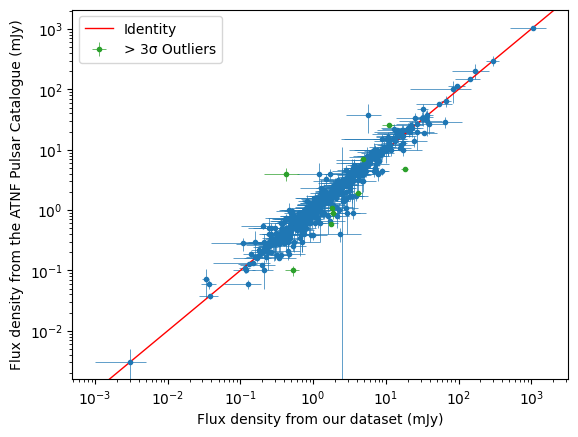

In [5]:
jname_list = list(param_est_10.keys())
atnf_latest_cat = collect_catalogue_from_ATNF(jname_list, atnf_ver='latest')
no_best_fit = ['J0511-6508', 'J0517+2212', 'J0536-7543', 'J0656-2228', 'J0711+0931', 'J0751+1807', 'J0834-4159', 'J0842-4851', 'J0901-4624', 'J1020-6026', 'J1028-5819', 'J1043-6116', 'J1052-5954', 'J1114-6100', 'J1126-6054', 'J1126-6942', 'J1302-6350', 'J1305-6203', 'J1357-6429', 'J1410-7404', 'J1420-6048', 'J1513-5739', 'J1534-5334', 'J1535-4114', 'J1626-4807', 'J1632-4757', 'J1636-4440', 'J1637-4642', 'J1638-4608', 'J1650-4502', 'J1652+2651', 'J1717-4054', 'J1727-2739', 'J1734-3333', 'J1735-3258', 'J1740+1000', 'J1747-2958', 'J1751-3323', 'J1758+3030', 'J1803-2137', 'J1804-0735', 'J1804-2717', 'J1806-2125', 'J1809-1917', 'J1812+0226', 'J1815-1738', 'J1816-1729', 'J1819+1305', 'J1820-1529', 'J1822-1400', 'J1824-2452A', 'J1825-1446', 'J1832-1021', 'J1837-0045', 'J1847-0438', 'J1852+0031', 'J1903+0327', 'J1910+0714', 'J1910+1231', 'J1914+1122', 'J1918+1444', 'J1921+1419', 'J2002+1637', 'J2008+2513', 'J2013+3845', 'J2038-3816', 'J2234+0611', 'J2307+2225']
print('Flux density comparison with the latest ATNF Pulsar Catalogue and our dataset:')

central_freq = 1400.
pul_cat_Ys = []
pul_cat_YERRs = []
pul_cat_YERRs_mod = []
atnf_Ys = []
atnf_YERRs = []
jnames = []

for jname in results_10.index:
    if jname not in atnf_latest_cat.cat_dict:
        continue
    if jname not in param_est_10:
        continue
    if jname in no_best_fit:
        continue
    
    pul_cat_Y_in_range = []
    pul_cat_YERR_in_range = []
    for i, freq in enumerate(catalogue.cat_dict[jname]['X']):
        if central_freq - 50. < freq < central_freq + 50.:
            pul_cat_Y_in_range.append(catalogue.cat_dict[jname]['Y'][i])
            pul_cat_YERR_in_range.append(catalogue.cat_dict[jname]['YERR'][i])
            
    if len(pul_cat_Y_in_range) < 1:
        continue
        
    atnf_Y_in_range = []
    atnf_YERR_in_range = []
    for i, freq in enumerate(atnf_latest_cat.cat_dict[jname]['X']):
        if central_freq - 50. < freq < central_freq + 50.:
            atnf_Y_in_range.append(atnf_latest_cat.cat_dict[jname]['Y'][i])
            atnf_YERR_in_range.append(atnf_latest_cat.cat_dict[jname]['YERR'][i])
                
    if len(atnf_Y_in_range) < 1:
        continue
        
    if len(pul_cat_Y_in_range) > 1:
        pul_cat_Y_in_range = np.array(pul_cat_Y_in_range)
        pul_cat_YERR_in_range = np.array(pul_cat_YERR_in_range)
        
        # Y is the median of the fluxes, YERR is the corresponding error
        pul_cat_Y = np.median(pul_cat_Y_in_range)
        pul_cat_YERR = pul_cat_YERR_in_range[np.argmin(np.abs(pul_cat_Y_in_range - pul_cat_Y))]
        
    else:
        pul_cat_Y = pul_cat_Y_in_range[0]
        pul_cat_YERR = pul_cat_YERR_in_range[0]
        
    # Best model
    best_model = results_10.loc[jname, 'best_fitting']
    sigma = param_est_10[jname][best_model]['median'][-1]
    # add sigma to the errors that are less than 10% of the flux
    if pul_cat_YERR < 0.1 * pul_cat_Y:
        pul_cat_YERR_mod = np.sqrt(pul_cat_YERR ** 2 + (sigma * pul_cat_Y) ** 2)
    else:
        pul_cat_YERR_mod = pul_cat_YERR
        
    if len(atnf_Y_in_range) > 1:
        atnf_Y_in_range = np.array(atnf_Y_in_range)
        atnf_YERR_in_range = np.array(atnf_YERR_in_range)
        
        # Y is the median of the fluxes, YERR is the corresponding error
        atnf_Y = np.median(atnf_Y_in_range)
        atnf_YERR = atnf_YERR_in_range[np.argmin(np.abs(atnf_Y_in_range - atnf_Y))]
        
    else:
        atnf_Y = atnf_Y_in_range[0]
        atnf_YERR = atnf_YERR_in_range[0]
        
    pul_cat_Ys.append(pul_cat_Y)
    pul_cat_YERRs.append(pul_cat_YERR)
    pul_cat_YERRs_mod.append(pul_cat_YERR_mod)
    atnf_Ys.append(atnf_Y)
    atnf_YERRs.append(atnf_YERR)
    jnames.append(jname)
        
def draw(pul_cat_Ys, pul_cat_YERRs, atnf_Ys, atnf_YERRs, jnames, title: str):
    # Group the data by outliers (> 3 sigma) and inliers
    pul_cat_Ys = np.array(pul_cat_Ys)
    pul_cat_YERRs = np.array(pul_cat_YERRs)
    atnf_Ys = np.array(atnf_Ys)
    atnf_YERRs = np.array(atnf_YERRs)
    jnames = np.array(jnames)
    
    outliers = np.abs(pul_cat_Ys - atnf_Ys) > 3 * np.sqrt(pul_cat_YERRs ** 2 + atnf_YERRs ** 2)
    pul_cat_Ys_outliers = pul_cat_Ys[outliers]
    pul_cat_YERRs_outliers = pul_cat_YERRs[outliers]
    atnf_Ys_outliers = atnf_Ys[outliers]
    atnf_YERRs_outliers = atnf_YERRs[outliers]
    jnames_outliers = jnames[outliers]
    
    print(f'Number of points: {len(pul_cat_Ys)}')
    print(f'Number of outliers: {len(pul_cat_Ys_outliers)}')
    model_count = {model: 0 for model in model_dict}
    for jname in jnames_outliers:
        if results_10.loc[jname, 'best_fitting'] in model_count:
            model_count[results_10.loc[jname, 'best_fitting']] += 1
    print('Outliers by model:')
    for model in model_count:
        print(f'- {model}: {model_count[model]}')
    
    pul_cat_Ys_inliers = pul_cat_Ys[~outliers]
    pul_cat_YERRs_inliers = pul_cat_YERRs[~outliers]
    atnf_Ys_inliers = atnf_Ys[~outliers]
    atnf_YERRs_inliers = atnf_YERRs[~outliers]
            
    # Draw a scatter plot
    plt.xscale('log')
    plt.yscale('log')
    plt.errorbar(pul_cat_Ys_inliers, atnf_Ys_inliers, xerr=pul_cat_YERRs_inliers, yerr=atnf_YERRs_inliers, fmt='o', elinewidth=0.5, color='tab:blue', markersize=3)
    plt.errorbar(pul_cat_Ys_outliers, atnf_Ys_outliers, xerr=pul_cat_YERRs_outliers, yerr=atnf_YERRs_outliers, fmt='o', label='> 3σ Outliers', elinewidth=0.5, color='tab:green', markersize=3)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.plot([0, 1e4], [0, 1e4], 'r-', label='Identity', linewidth=1)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel('Flux density from our dataset (mJy)')
    plt.ylabel('Flux density from the ATNF Pulsar Catalogue (mJy)')
    plt.legend()
    plt.savefig(title + '.pdf', bbox_inches='tight')
    plt.show()

print('Without systematic error:')
draw(pul_cat_Ys, pul_cat_YERRs, atnf_Ys, atnf_YERRs, jnames, 'Flux density comparison with ATNF catalogue (without systematic error)')
print('With systematic error:')
draw(pul_cat_Ys, pul_cat_YERRs_mod, atnf_Ys, atnf_YERRs, jnames, 'Flux density comparison with ATNF catalogue (with systematic error)')